In [159]:
import pandas as pd
import seaborn as sns
from missingno import missingno
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

Зчитуємо тренувальні та тестувальні дані з відповідних файлів

In [160]:
df_train = pd.read_csv("application_train.csv")
df_test = pd.read_csv("application_test.csv")
print(df_train.head())
print(df_test.head())

   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0             

Як бачимо, вони мають однакові колонки, тільки у тестувальних даних немає колонки target

In [33]:
print(f"Кількість об'єктів у тренувальній вибірці: {len(df_train)}")
print(f"Кількість об'єктів у тестувальній вибірці: {len(df_test)}")

Кількість об'єктів у тренувальній вибірці: 307511
Кількість об'єктів у тестувальній вибірці: 48744


In [34]:
print(df_train.dtypes.value_counts())

float64    65
int64      41
object     16
Name: count, dtype: int64


Графічно перевіримо дані на наявність пропусків

<Axes: >

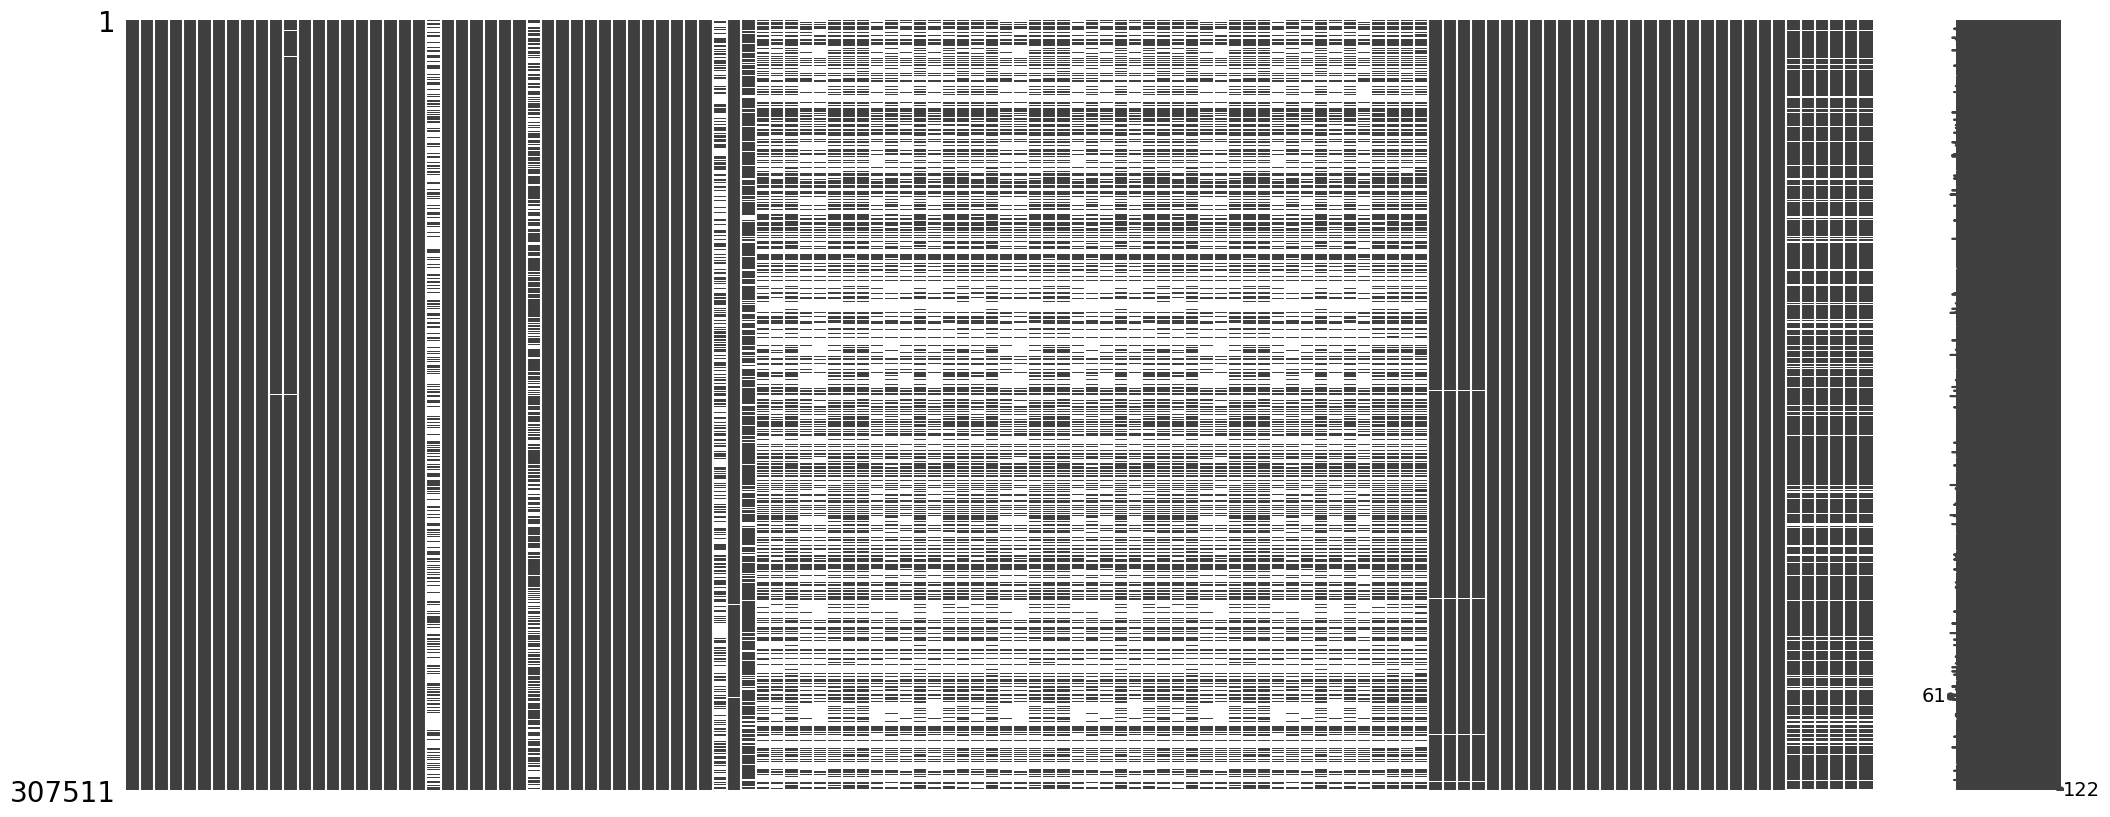

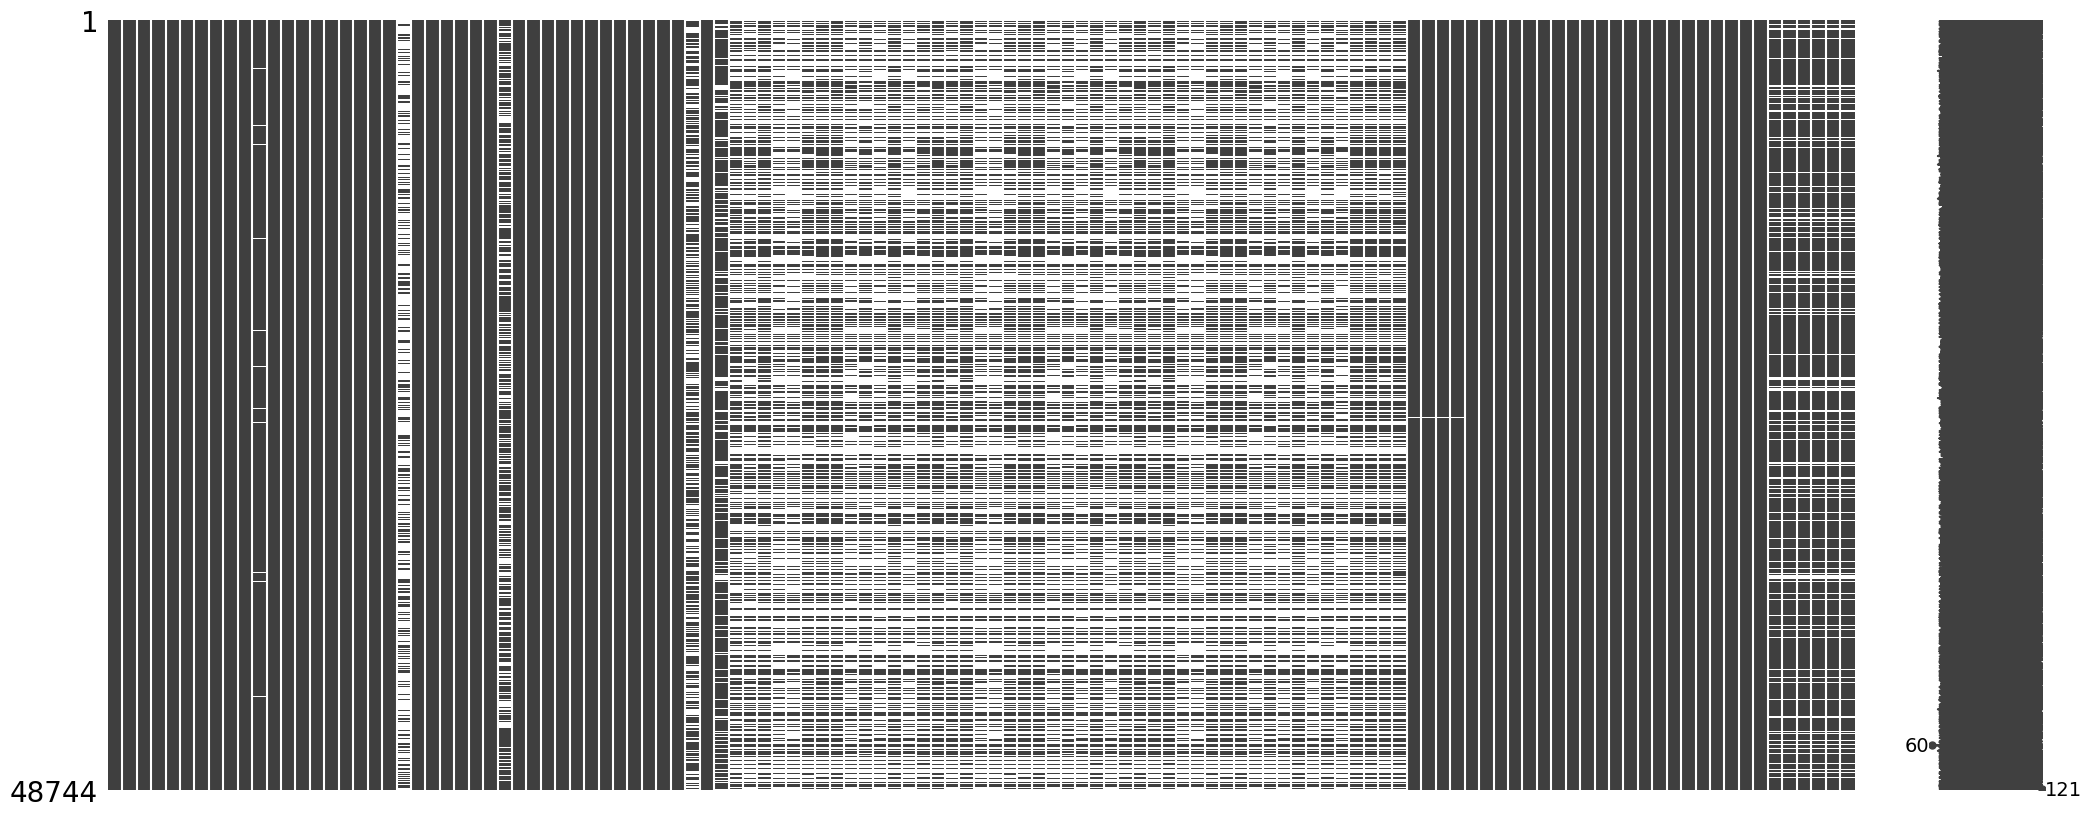

In [161]:
missingno.matrix(df_train)
missingno.matrix(df_test)

Як бачимо, пропуски присутні, як в тренувальних так і в тестових даних. Створимо функцію, яка буде виводити кількість пропусків у стовпчику та його тип даних

In [166]:
def find_missing(data_frame):
    nan_columns = data_frame.isnull().sum()
    nan_columns = nan_columns[nan_columns > 0]
    data_types = data_frame[nan_columns.index].dtypes

    missing_value = pd.concat([nan_columns, data_types], axis=1)
    missing_value.columns=["Amount of missing value", "Data type"]
    print(missing_value)

find_missing(df_train)
print("#################################################################")
find_missing(df_test)

                            Amount of missing value Data type
AMT_ANNUITY                                      12   float64
AMT_GOODS_PRICE                                 278   float64
NAME_TYPE_SUITE                                1292    object
OWN_CAR_AGE                                  202929   float64
OCCUPATION_TYPE                               96391    object
...                                             ...       ...
AMT_REQ_CREDIT_BUREAU_DAY                     41519   float64
AMT_REQ_CREDIT_BUREAU_WEEK                    41519   float64
AMT_REQ_CREDIT_BUREAU_MON                     41519   float64
AMT_REQ_CREDIT_BUREAU_QRT                     41519   float64
AMT_REQ_CREDIT_BUREAU_YEAR                    41519   float64

[67 rows x 2 columns]
#################################################################
                            Amount of missing value Data type
AMT_ANNUITY                                      24   float64
NAME_TYPE_SUITE                            

Пропуски в колонках з типом object будемо заповнювати модою цього стовбчика, а пропуски в колонках, де маємо числовий тип, заповнимо середніми значеннями.

In [168]:
columns_with_object_type = df_train.select_dtypes(include='object').columns
object_missing = df_train[columns_with_object_type].isnull().sum()
object_missing = object_missing[object_missing > 0].index

for column in object_missing:
    mode = df_train[column].mode()[0] # У випадку, якщо мод декілька, беремо першу.
    df_train[column] = df_train[column].fillna(mode)

In [169]:
columns_with_numeric_type = df_train.select_dtypes(include=['int64', 'float64']).columns
numeric_missing = df_train[columns_with_numeric_type].isnull().sum()
numeric_missing = numeric_missing[numeric_missing > 0].index

for column in numeric_missing:
    mean = df_train[column].mean()
    df_train[column] = df_train[column].fillna(mean)

Так само і для тестової множини.

In [170]:
test_columns_with_object_type = df_test.select_dtypes(include='object').columns
test_object_missing = df_test[test_columns_with_object_type].isnull().sum()
test_object_missing = test_object_missing[test_object_missing > 0].index

for column in test_object_missing:
    mode = df_test[column].mode()[0] # У випадку, якщо мод декілька, беремо першу.
    df_test[column] = df_test[column].fillna(mode)

test_columns_with_numeric_type = df_test.select_dtypes(include=['int64', 'float64']).columns
test_numeric_missing = df_test[test_columns_with_numeric_type].isnull().sum()
test_numeric_missing = test_numeric_missing[test_numeric_missing > 0].index

for column in test_numeric_missing:
    mean = df_test[column].mean()
    df_test[column] = df_test[column].fillna(mean)

Перевіримо чи залишились якісь пропуски

In [171]:
find_missing(df_train)
find_missing(df_test)

Empty DataFrame
Columns: [Amount of missing value, Data type]
Index: []
Empty DataFrame
Columns: [Amount of missing value, Data type]
Index: []


<Axes: >

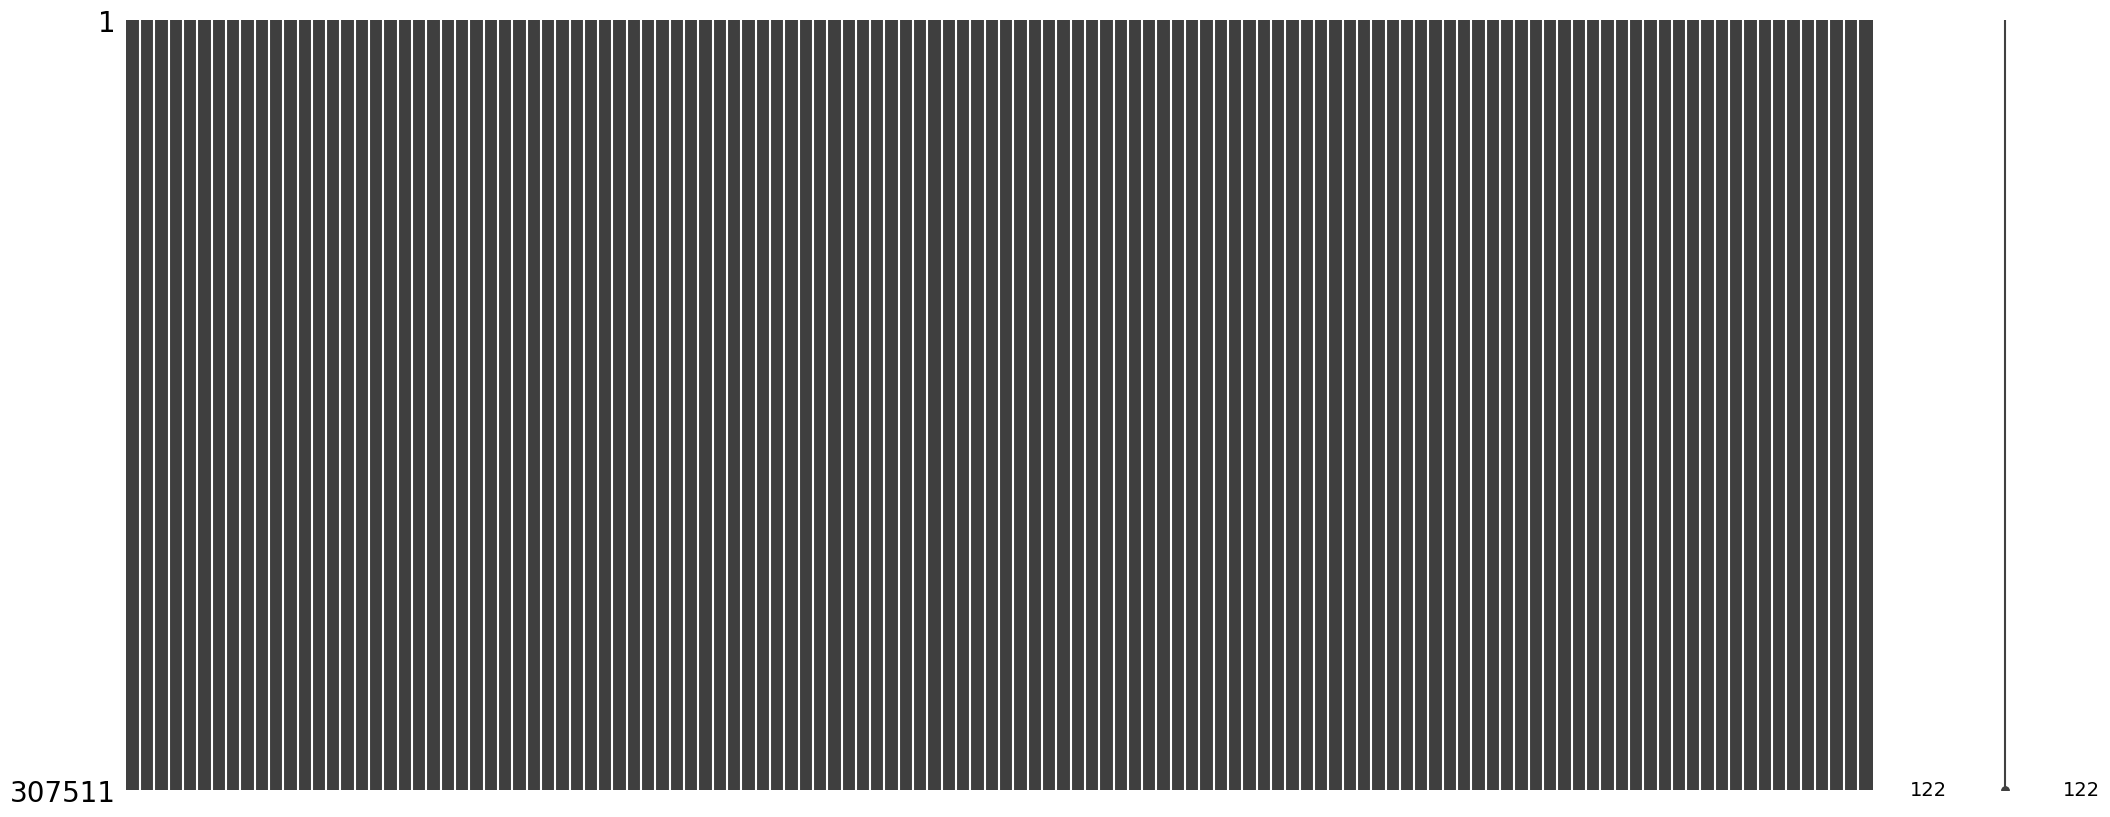

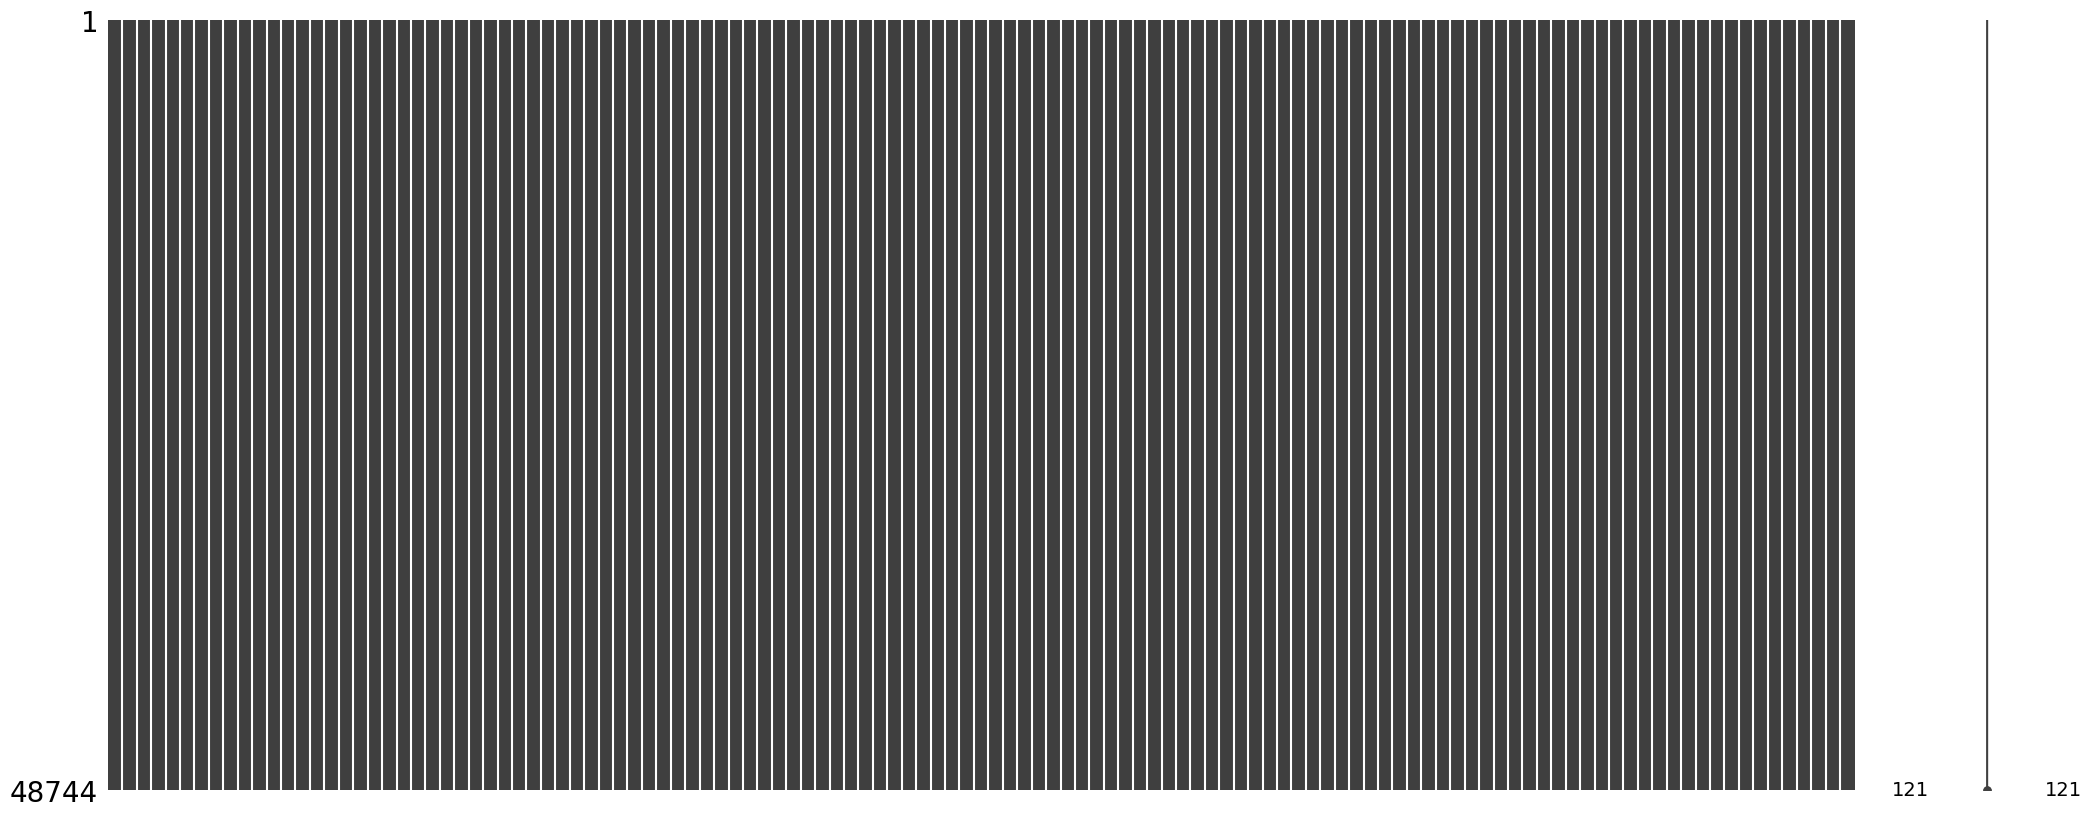

In [172]:
missingno.matrix(df_train)
missingno.matrix(df_test)

Перевіримо збалансованість класів:

Кількість елементів у кожному класі:
TARGET
0    282686
1     24825
Name: count, dtype: int64


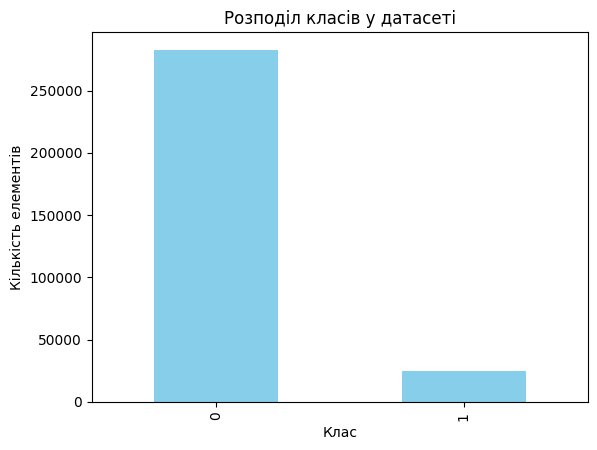

In [173]:
class_counts = df_train['TARGET'].value_counts()

print("Кількість елементів у кожному класі:")
print(class_counts)

class_counts.plot(kind='bar', color='skyblue')
plt.title('Розподіл класів у датасеті')
plt.xlabel('Клас')
plt.ylabel('Кількість елементів')
plt.show()

In [89]:
X_train = df_train.drop(columns="TARGET")
y_train = df_train["TARGET"]

Тепер для X_train перетворимо дані типу object на числові дані. У колонках, де дані бінарні будемо використовувати звичайний Label Encoding, а у тих колонках, де варіацій значень більше ніж дві, будемо використовувати One-Hot Encoding.

In [90]:
print(X_train.dtypes.value_counts())

float64    65
int64      40
object     16
Name: count, dtype: int64


Перетворюємо всі дані на числові

In [91]:
label_encoder_columns = [column for column in X_train.columns if X_train[column].dtype == 'object']

label_encoder = LabelEncoder()
for column in label_encoder_columns:
    X_train[column] = label_encoder.fit_transform(X_train[column])

У колонках де варіацій значень більше ніж 2 використаємо One-Hot Encoder

In [92]:
one_hot_encoder_columns = [column for column in X_train.columns if X_train[column].dtype == 'object' and len(X_train[column].unique()) > 2]

X_train = pd.get_dummies(X_train, columns=one_hot_encoder_columns, drop_first=True)

Теж саме й для тестової множини

In [149]:
label_encoder_test_columns = [column for column in df_test.columns if df_test[column].dtype == 'object']

for column in label_encoder_test_columns:
    df_test[column] = label_encoder.fit_transform(df_test[column])

one_hot_encoder_test_columns = [column for column in df_test.columns if df_test[column].dtype == 'object' and len(df_test[column].unique()) > 2]

df_test = pd.get_dummies(df_test, columns=one_hot_encoder_test_columns, drop_first=True)

In [93]:
print(X_train.dtypes.value_counts())

float64    65
int64      40
int32      16
Name: count, dtype: int64


Візуалізуємо діапазони значень

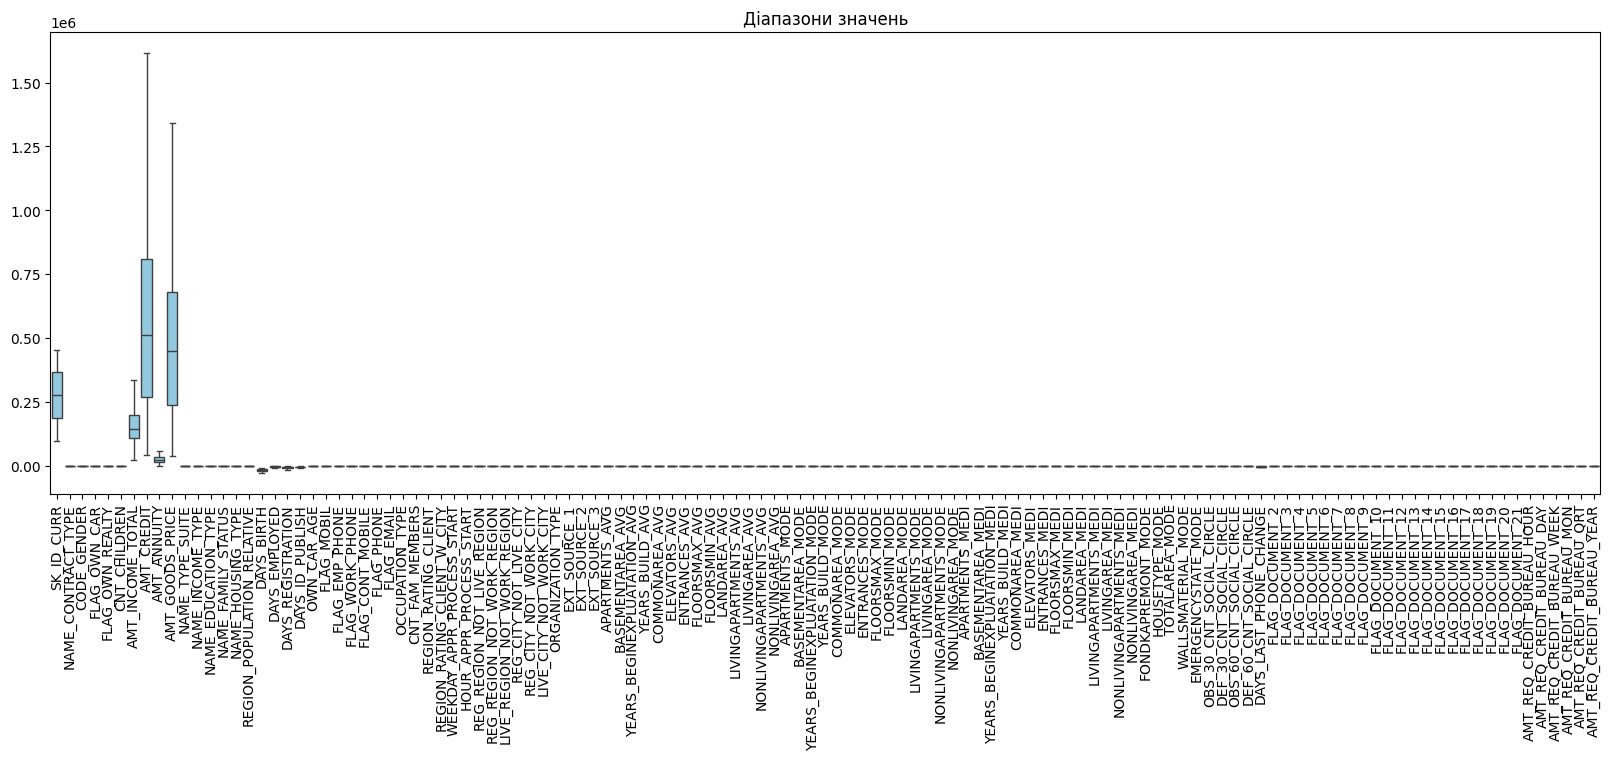

In [94]:
plt.figure(figsize=(20, 6))  # Визначення розміру графіку
sns.boxplot(data=X_train, color='skyblue', showfliers=False)
plt.xticks(rotation=90)
plt.title('Діапазони значень')
plt.show()

Бачимо, що розподіл даних дуже нерівномірний, тому пронормуємо їх.

In [97]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

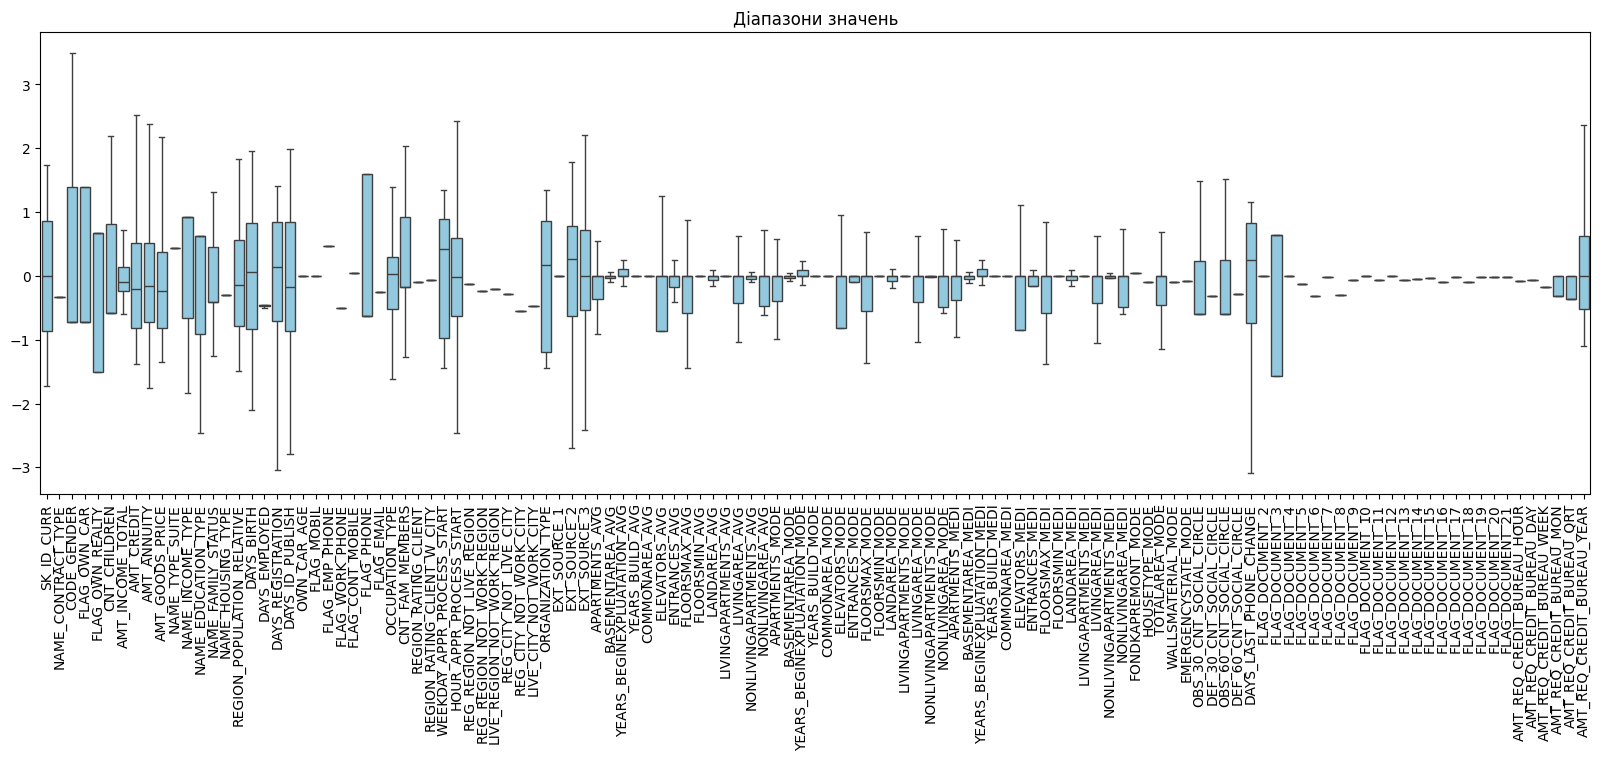

In [98]:
plt.figure(figsize=(20, 6))  # Визначення розміру графіку
sns.boxplot(data=X_train, color='skyblue', showfliers=False)
plt.xticks(rotation=90)
plt.title('Діапазони значень')
plt.show()

Поділимо тренувальні дані на тренувальні та валідаційні

In [101]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

Створимо модель логістичної регресії для класифікації наших даних.

Було обрано логістичну регресію бо, вона є простим та ефективним алгоритмом для бінарної класифікації, який може працювати добре з незбалансованими даними, особливо якщо використовуються методи регуляризації для контролю перенавчання.

Для валідації використаємо ROC_AUC метрику

In [146]:
model = LogisticRegression(class_weight = "balanced", solver='newton-cholesky')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_val = roc_auc_score(y_val, y_val_pred)

print(f"ROC-AUC train score: {roc_auc_train}")
print(f"ROC-AUC validation score: {roc_auc_train}")

ROC-AUC train score: 0.6814683349794806
ROC-AUC validation score: 0.6814683349794806


Було отримано задовільні результати

Візуалізуємо їх за допомогою ROC кривої

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


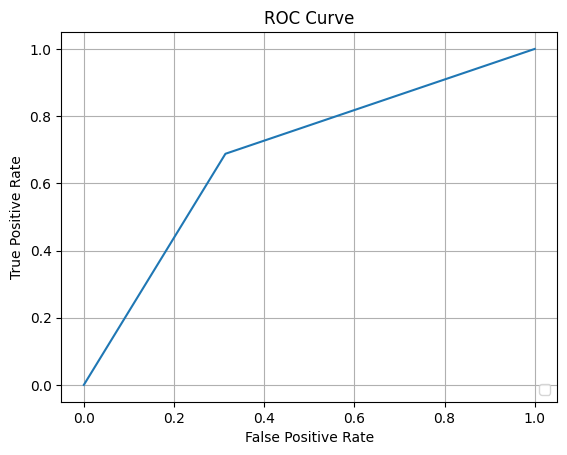

In [147]:
from sklearn.metrics import roc_curve, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

Зробимо передбачення на тестовій вибірці

In [154]:
pred = model.predict(df_test)
print(pred)

[1 0 0 ... 0 0 1]


Запишемо результати у .csv файл

In [158]:
columns = ['SK_ID_CURR', 'TARGET']

submission = pd.DataFrame(columns=columns)

submission['SK_ID_CURR'] = df_test['SK_ID_CURR']
submission['TARGET'] = pred

filename = 'submission.csv'
submission.to_csv(filename, index=False)